In [4]:
%load_ext autoreload
%autoreload 2

import pathlib
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np

from typing import List, Dict

plt.rcParams["font.size"] = "15"
matplotlib.rc('figure', figsize=[6,4])

from data_handlers.runtimes import *
from data_handlers.preprocessors import node_types

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def progress_bar(current, maximum):
    executed_percent = int(round((current / maximum) * 100))
    print(f"\r[", end="")
    print(f"#" * executed_percent, end="")
    print(f"_" * (100 - executed_percent), end="")
    print(f"]", end="")
    
    if executed_percent == 100:
        print(f" Done", end="")
    else:
        print(f" {executed_percent}%", end="")

# Parse Experiments

In [6]:
experiment_path = pathlib.Path(f"/home/jovyan/work/binary_files/")

In [7]:
event_frame: pd.DataFrame
event_frame = parse_bundle_events(experiment_path)

Parsing /home/jovyan/work/binary_files/context_epidemic/22
Parsing /home/jovyan/work/binary_files/context_epidemic/23
Parsing /home/jovyan/work/binary_files/context_epidemic/24
Parsing /home/jovyan/work/binary_files/context_epidemic/25
Parsing /home/jovyan/work/binary_files/context_epidemic/26
Parsing /home/jovyan/work/binary_files/epidemic/2
Parsing /home/jovyan/work/binary_files/epidemic/3
Parsing /home/jovyan/work/binary_files/epidemic/4
Parsing /home/jovyan/work/binary_files/epidemic/5
Parsing /home/jovyan/work/binary_files/epidemic/6
Parsing /home/jovyan/work/binary_files/spray/7
Parsing /home/jovyan/work/binary_files/spray/8
Parsing /home/jovyan/work/binary_files/spray/9
Parsing /home/jovyan/work/binary_files/spray/10
Parsing /home/jovyan/work/binary_files/spray/11
Parsing /home/jovyan/work/binary_files/prophet/12
Parsing /home/jovyan/work/binary_files/prophet/13
Parsing /home/jovyan/work/binary_files/prophet/14
Parsing /home/jovyan/work/binary_files/prophet/15
Parsing /home/jovy

In [8]:
types = node_types(scenario_path="/home/jovyan/work/scenarios/wanderwege/wanderwege.xml")
type_frame = pd.DataFrame(types.items(), columns=["node", "node_type"])

In [9]:
event_frame = event_frame.merge(type_frame, how="left", on="node")

# Compute and plot Total Number of Forwards

In [10]:
def bundle_distribution(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame.set_index("timestamp")
    instances = simulation_data[simulation_data.event == "reception"].groupby("sim_instance_id")
    runtimes = []
    
    big_fat_dataframe = DataFrame()
    for _, instance in instances:
        simulation_start = instance.index[0]
        instance["since_start"] = instance.index - simulation_start
        instance = instance.set_index("since_start")
        new_bundles = instance.groupby(pd.Grouper(freq='1Min')).apply(len).to_frame()
        new_bundles = new_bundles.rename(columns={0: "reception_count"})
        
        while len(new_bundles) <= 60:
            new_bundles = new_bundles.append({"reception_count": 0}, ignore_index=True)
        
        new_bundles["sim_instance_id"] = instance["sim_instance_id"][0]
        new_bundles["routing"] = instance["routing"][0]
        new_bundles["reception_accumulated"] = new_bundles["reception_count"].cumsum()
        
        new_bundles.loc[new_bundles['routing'] == 'epidemic', 'routing'] = 'Epidemic'
        new_bundles.loc[new_bundles['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
        new_bundles.loc[new_bundles['routing'] == 'prophet', 'routing'] = 'Prophet'
        new_bundles.loc[new_bundles['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
        new_bundles.loc[new_bundles['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
        new_bundles.loc[new_bundles['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
        new_bundles.loc[new_bundles['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
        
        big_fat_dataframe = big_fat_dataframe.append(new_bundles)
        
    return big_fat_dataframe
        

big_fat_dataframe = bundle_distribution(event_frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


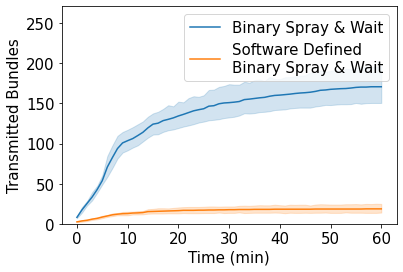

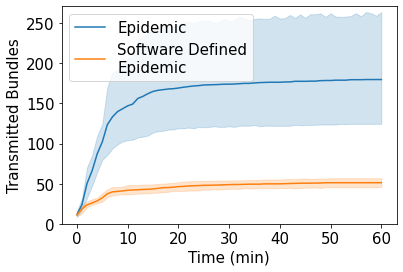

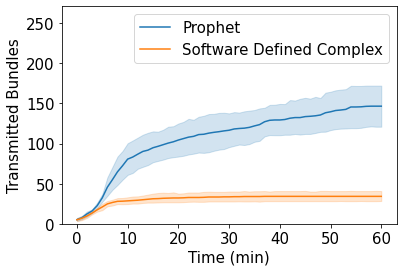

In [11]:
def plot_accumulated(groups):
    cleared_df = big_fat_dataframe[big_fat_dataframe['routing'].isin(groups)]
    
    ax = sns.lineplot(
        x=cleared_df.index,
        y='reception_accumulated',
        data=cleared_df,
        hue="routing",
        legend="full",
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    ax.set(xlabel='Time (min)', ylabel='Transmitted Bundles', ylim=[0,271])

    plt.show()

groups = [
    ["Binary Spray & Wait", "Software Defined\nBinary Spray & Wait"],
    ["Epidemic", "Software Defined\nEpidemic"],
    ["Prophet", "DTLSR", "Software Defined Complex"],
]

for group in groups:
    plot_accumulated(group)

# Compute and plot Average End-to-End Delay

In [58]:
def bundle_runtimes(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame #.set_index("timestamp")
    creation_instances = simulation_data[simulation_data.event == "creation"]
    
    delivery_instances = simulation_data[simulation_data.event == "delivery"].groupby(["sim_instance_id", "bundle"])
    
    big_fat_dataframe = pd.DataFrame()
    _len = len(delivery_instances)
    i = 0
    for name, instance in delivery_instances:
        progress_bar(i, _len)
        i += 1
        
        sim_instance_id, bundle = name
        
        instance = instance.sort_values("timestamp")
        delivery_row = instance.iloc[0]
        delivery_time = delivery_row["timestamp"]
        
        creation_row = creation_instances[creation_instances.bundle == bundle]
        if creation_row.empty: # TODO: Remove, after context bundles are ignored!
            continue
        creation_time = creation_row["timestamp"].iloc[0]
        runtime = delivery_time - creation_time
        if runtime < pd.Timedelta(100,'ms'):
            continue
        
        runtime_dict = {
            "sim_instance_id": sim_instance_id,
            "bundle": bundle,
            "runtime": (runtime.to_pytimedelta() / timedelta(milliseconds=1)) / 1000,
            "routing": creation_row["routing"].values[0]
        }
        
        big_fat_dataframe = big_fat_dataframe.append(runtime_dict, ignore_index=True)
        
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'epidemic', 'routing'] = 'Epidemic'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'prophet', 'routing'] = 'Prophet'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
    
    return big_fat_dataframe

runtimes = bundle_runtimes(event_frame)

[####################################################################################################] Done__________________________________________________________________________________________________] 0%#___________________________________________________________________________________________________] 1%##__________________________________________________________________________________________________] 2%####________________________________________________________________________________________________] 4%####________________________________________________________________________________________________] 4%#####_______________________________________________________________________________________________] 5%#####_______________________________________________________________________________________________] 5%######______________________________________________________________________________________________] 6%######_________________________________________________________

In [13]:
runtimes.head()

,bundle,routing,runtime,sim_instance_id
0,dtn://n17/-648646574-0,binary_spray,530758.388,10
1,dtn://n21/-648646515-0,binary_spray,1340.685,10
2,dtn://n21/-648646887-0,binary_spray,34047.087,10
3,dtn://n21/-648647131-0,binary_spray,173.730,10
4,dtn://n21/-648647264-0,binary_spray,187.541,10


[Text(0, 0, 'Binary Spray & Wait'),
 Text(0, 0, 'Prophet'),
 Text(0, 0, 'Epidemic'),
 Text(0, 0, 'Software Defined\nEpidemic'),
 Text(0, 0, 'Software Defined\nBinary Spray & Wait'),
 Text(0, 0, 'Software Defined Complex')]

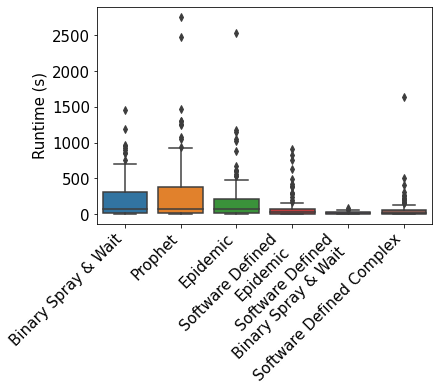

In [60]:
ax = sns.boxplot(x="routing", y="runtime", data=runtimes)
ax.set(xlabel='', ylabel='Runtime (s)')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)

In [15]:
bundles: List[str]
successful: List[str]
unsuccessful: List[str]
runtimes_df: pd.DataFrame

bundles, successful, unsuccessful, runtimes_df = compute_bundle_runtimes(event_frame=event_frame)

KeyboardInterrupt: 

In [ ]:
touched_nodes: Dict[str, List[str]] = {}
touched_node_types: Dict[str, List[str]] = {}
number_of_nodes: Dict[str, int] = {}

for bundle in bundles:
    bundle_nodes = event_frame[event_frame.bundle == bundle].node.unique().tolist()
    touched_nodes[bundle] = bundle_nodes
    number_of_nodes[bundle] = len(bundle_nodes)
    bundle_node_types = set()
    for node in bundle_nodes:
        bundle_node_types.add(types[node])
    touched_node_types[bundle] = list(bundle_node_types)

In [42]:
def bundles_delivered(event_frame: pd.DataFrame) -> DataFrame:
    creation_instances = event_frame[event_frame.event == "creation"].groupby(["sim_instance_id"])
    
    delivery_instances = event_frame[event_frame.event == "delivery"]
    
    big_fat_dataframe = pd.DataFrame()
    for sim_instance_id, instance in creation_instances:
        for _, row in instance.iterrows():
            bundle = row["bundle"]
            was_delivered = not delivery_instances[delivery_instances["bundle"] == bundle].empty
            row_dict = {
                "sim_instance_id": sim_instance_id,
                "bundle": bundle,
                "delivered": was_delivered,
                "routing": row["routing"]
            }
            big_fat_dataframe = big_fat_dataframe.append([row_dict], ignore_index=True)
            
    return big_fat_dataframe   

In [43]:
delivery_df = bundles_delivered(event_frame)
delivery_df.head(100)

,sim_instance_id,bundle,delivered,routing
0,10,dtn://n47/-648646169-0,True,binary_spray
1,10,dtn://n25/-648646176-0,True,binary_spray
2,10,dtn://n45/-648646184-0,True,binary_spray
3,10,dtn://n23/-648646209-0,True,binary_spray
4,10,dtn://n50/-648646255-0,True,binary_spray
5,10,dtn://n37/-648646261-0,True,binary_spray
6,10,dtn://n18/-648646274-0,False,binary_spray
7,10,dtn://n44/-648646280-0,False,binary_spray
8,10,dtn://n27/-648646280-0,True,binary_spray
9,10,dtn://n51/-648646290-0,True,binary_spray


In [64]:
def delivery_percentage(big_fat_dataframe) -> DataFrame:
    small_dataframe = pd.DataFrame()
    for name, bundles in big_fat_dataframe.groupby(["routing", "sim_instance_id"]):
        routing, sim_instance_id = name
        total_bundles = len(bundles.index)
        delivered_bundles = len(bundles[bundles.delivered == True].index)
        row_dict = {
            "routing": routing,
            "sim_instance_id": sim_instance_id,
            "delivery_percentage": (float(delivered_bundles) / float(total_bundles)) * 100
        }
        small_dataframe = small_dataframe.append([row_dict], ignore_index=True)
        
    small_dataframe.loc[small_dataframe['routing'] == 'epidemic', 'routing'] = 'Epidemic'
    small_dataframe.loc[small_dataframe['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
    small_dataframe.loc[small_dataframe['routing'] == 'prophet', 'routing'] = 'Prophet'
    small_dataframe.loc[small_dataframe['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
    small_dataframe.loc[small_dataframe['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
    small_dataframe.loc[small_dataframe['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
    small_dataframe.loc[small_dataframe['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
    
    return small_dataframe

In [65]:
delivery_percentage_df = delivery_percentage(delivery_df)
print(delivery_percentage_df)

                                  routing sim_instance_id  delivery_percentage
0                     Binary Spray & Wait              10            16.733068
1                     Binary Spray & Wait              11            13.223140
2                     Binary Spray & Wait               7            15.720524
3                     Binary Spray & Wait               8            11.607143
4                     Binary Spray & Wait               9            16.129032
5                Software Defined Complex              32            18.571429
6                Software Defined Complex              33            14.876033
7                Software Defined Complex              34            13.513514
8                Software Defined Complex              35            20.300752
9                Software Defined Complex              36             9.160305
10             Software Defined\nEpidemic              22            22.627737
11             Software Defined\nEpidemic           

[Text(0, 0, 'Binary Spray & Wait'),
 Text(0, 0, 'Software Defined Complex'),
 Text(0, 0, 'Software Defined\nEpidemic'),
 Text(0, 0, 'Software Defined\nBinary Spray & Wait'),
 Text(0, 0, 'Epidemic'),
 Text(0, 0, 'Prophet')]

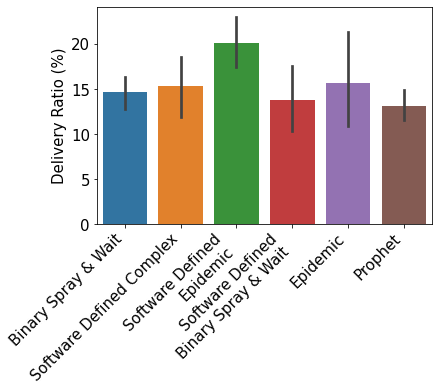

In [66]:
ax = sns.barplot(x="routing", y="delivery_percentage", data=delivery_percentage_df)
ax.set(xlabel='', ylabel='Delivery Ratio (%)')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)